In [1]:
%matplotlib inline
%load_ext line_profiler
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt
from scipy.stats import logistic
from scipy.special import softmax

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras.utils import to_categorical
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10

import tensorflow as tf

from pixelcnn_helpers import pixelcnn_loss, sigmoid, compute_pvals, compute_mixture, PixelConv2D

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
img_rows, img_cols, img_chns = 32, 32, 3
original_img_size = (img_rows, img_cols, img_chns)

# Debug params
num_sample = 2

# Hyper params
batch_size = int(os.environ.get('BATCH_SIZE', 10))
epochs = int(os.environ.get('EPOCHS', 1000))
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
mixture_components = int(os.environ.get('MIXTURE_COMPONENTS', 5))

# Extract Test Image

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Shift/scale to [-1, 1] interval
X_train = X_train[:num_sample, :img_rows, :img_cols, :img_chns]
X_train = (X_train - 127.5) / 127.5

X_test = (X_test - 127.5) / 127.5

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


# Model

In [4]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1
    
    
def conv_block(input_tensor, filters, kernel_size, name, is_first=False):
    outs = []
    for t in ['rb', 'gb', 'bb']:
        if is_first:
            t = t[0] + 'a'
        x = PixelConv2D(t, filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)


def resnet_block(input_tensor, filters, stage, block):
    name_base = str(stage) + block + '_branch'
    filters1, filters2, filters3 = filters
    x = input_tensor
    x = conv_block(x, filters1, (1, 1), name=name_base + '_a-1x1')
    x = conv_block(x, filters2, (3, 3), name=name_base + '_b-3x3')
    x = conv_block(x, filters3, (1, 1), name=name_base + '_c-1x1')
    x = Add()([x, input_tensor])
    
    return x


def final_block(input_tensor, filters, in_filters, name, kernel_size=(1, 1)):
    outs = []
    channel_name = 'rgb'
    for t in ['rb', 'gb', 'bb']:
        x = PixelConv2D(t, filters, kernel_size, 
                        name='final' + name + '_' + t,
                        padding='same')(input_tensor)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)


def build_outputs(input_tensor, final_filters):
    m_outs = []
    invs_outs = []
    weights = []
    for t in ['rb', 'gb', 'bb']:
        # Only allow things behind it...
        x = input_tensor
        decoder_out_m = PixelConv2D(t, name='x_m' + str(t),
                                    filters=mixture_components,
                                    kernel_size=1,
                                    strides=1)(x)
        decoder_out_invs_ = PixelConv2D(t, name='x_s' + str(t),
                                        filters=mixture_components,
                                        kernel_size=1,
                                        strides=1,
                                        activation='softplus')(x)
        decoder_out_invs = Lambda(lambda x: 5. * x + 3.0)(decoder_out_invs_)
        mixture_weights = PixelConv2D(t, name='weights' + str(t),
                                      filters=mixture_components,
                                      kernel_size=1,
                                      strides=1)(x)
        m_outs.append(decoder_out_m)
        invs_outs.append(decoder_out_invs)
        weights.append(mixture_weights)
    
    out_m = Concatenate()(m_outs)       
    out_invs = Concatenate()(invs_outs)       
    out_mixture = Concatenate()(weights)       
    return Concatenate()([out_m, out_invs, out_mixture])

In [5]:
# Work around Keras/tensorboard bug: https://github.com/keras-team/keras/issues/10074
K.clear_session()

print("Building conv layers...")
main_input = Input(shape=original_img_size, name='main_input')

x = conv_block(main_input, 256, (7, 7), name='conv1', is_first=True)

resnet_depth = 15
for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage, 'a')
#final_width = 256

final_width = 1024
x = final_block(x, final_width, 256, '1x1_1000_1')
x = final_block(x, final_width, final_width, '1x1_1000_2')

print("Building output layers...")
outputs = build_outputs(x, final_width)
main_output = outputs

print("Building model...")
model = Model(inputs=main_input, outputs=main_output)
optimizer = Adam(lr=0.001)
#optimizer = RMSprop(lr=0.001)
model.compile(optimizer=optimizer, 
              loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, mixture_components))

model.summary()

Building conv layers...
Building output layers...
Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
resconv1ra (PixelConv2D)        (None, 32, 32, 256)  37888       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ga (PixelConv2D)        (None, 32, 32, 256)  37888       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ba (PixelConv2D)        (None, 32, 32, 256)  37888       main_input[0][0]                 
_________________________________________

In [6]:
early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=2.0, patience=50)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=15, min_lr=0.0001)
filepath='./checkpoints/model-weights-2019-05-30.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto', period=10)

#tensorboard = keras.callbacks.TensorBoard(log_dir='./logs_2019-05-13/' + str(int(time.time() % 10000)),
#                                          histogram_freq=1, batch_size=1,
#                                          write_grads=True, write_images=True, update_freq='batch')

history = model.fit(
    X_train, X_train,
    batch_size=batch_size,
    #epochs=epochs,
    epochs=1000,
    callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],#, checkpoint],#, tensorboard],
    #validation_data=(X_train, X_train),
    verbose=0
)

,loss,lr
count,900.000000,900.000000
mean,13455.593183,0.000427
std,28644.390804,0.000400
min,5473.041016,0.000100
0%,5473.041016,0.000100
25%,7468.595459,0.000100
50%,10399.990234,0.000250
75%,14288.494629,0.001000
95%,21826.345898,0.001000
99%,56013.821445,0.001000


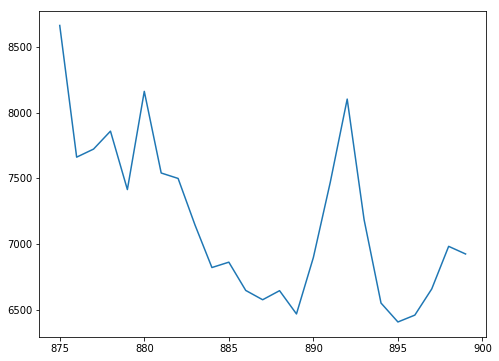

In [7]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'][-25:].plot(figsize=(8, 6))

In [8]:
#model.load_weights(filepath)
#model.compile(optimizer=optimizer, 
#              loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, mixture_components))

In [9]:
debug = True

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                # =======================================================
                #x_out = model.predict(X_train, num_samples)
                x_out = model.predict(x_sample, num_samples)
                for n in range(num_samples):
                    offset = k * mixture_components
                    x_ms = x_out[n, i, j, offset:offset + mixture_components]
                    offset = mixture_components * img_chns + k * mixture_components

                    x_invs = x_out[n, i, j, offset:offset + mixture_components]
                    offset = 2 * mixture_components * img_chns + k * mixture_components
                    weights = softmax(x_out[n, i, j, offset:offset + mixture_components])
                    pvals = compute_mixture(x_ms, x_invs, weights, mixture_components)
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = (pixel_val - 127.5) / 127.5
                    if 0 <= i <= 3 and 0 <= j <= 3 and n == 0 and debug:
                        print("====", i, j, k)
                        print("X_train[0", i, j, k, "] = ", X_train[0, i, j, k], 
                              " (%s)" % (X_train[0, i, j, k] * 127.5 + 127.5))
                        print(" m: ", x_ms, "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" E[m]: ", (x_ms * weights).sum(), "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" invs: ", x_invs)
                        print(" weights: ", weights, " (", x_out[n, i, j, offset:offset + mixture_components] ,")")
                        s = pd.Series(pvals)
                        print(" pvals: ", s[s>1e-2])
                        print(" pixel_val: ", pixel_val)
                        samples = pd.Series(np.random.choice(len(pvals), 1000, p=pvals / pvals.sum()))
                        samples.hist(bins=128, alpha=0.5, label='generated')
                        #print("====", i, j, k)
                        #print(" m: ", x_ms)
                        #print(" invs: ", x_invs)
                        #print(" weights: ", weights)
                        #print(" pixel_val: ", pixel_val)
                        #print(" x_out[n, i, j, :]: ", x_out[n, i, j, :])
                        #print(" x_out: ", x_out)
                        #print(" sample_val: ", x_sample[n, i, j, k])
                        #print(" pvals: ", pvals)
        #if debug:
        print("row", i)
        
                
    return (x_sample * 127.5 + 127.5)


In [10]:
#%lprun -f compute_mixture gen_image(model, 2)

(32, 320, 3)
==== 0 0 0
X_train[0 0 0 0 ] =  -0.5372549019607843  (59.0)
 m:  [ 0.37291127 -0.03699508  0.16684933  0.06269228 -0.43870372] ([175.04619 122.78313 148.77328 135.49327  71.56528])
 E[m]:  0.05986134 ([175.04619 122.78313 148.77328 135.49327  71.56528])
 invs:  [4.403063  3.967288  3.8234262 6.338008  3.9919991]
 weights:  [0.01394598 0.06465999 0.04401201 0.8668203  0.01056179]  ( [-1.4471561   0.08679505 -0.29788494  2.6824841  -1.7251052 ] )
 pvals:  134    0.010650
135    0.429716
136    0.417358
137    0.010026
dtype: float64
 pixel_val:  136
==== 0 0 1
X_train[0 0 0 1 ] =  -0.5137254901960784  (62.0)
 m:  [ 0.1963196  -0.881951    0.23619398 -0.9825976   0.76093584] ([152.53075   15.051254 157.61473    2.218811 224.51932 ])
 E[m]:  0.21138775 ([152.53075   15.051254 157.61473    2.218811 224.51932 ])
 invs:  [4.8317165 4.582861  5.7734795 4.400836  4.1473427]
 weights:  [0.02877463 0.01125433 0.94769156 0.01004764 0.00223179]  ( [-0.78775203 -1.7264928   2.7067828  -

==== 1 1 0
X_train[0 1 1 0 ] =  -1.0  (0.0)
 m:  [ 0.26877284 -0.03865234  0.10742477  0.01963351 -0.3295501 ] ([161.76854 122.57182 141.19666 130.00328  85.48236])
 E[m]:  0.018513434 ([161.76854 122.57182 141.19666 130.00328  85.48236])
 invs:  [4.8131776 4.3966093 4.2508144 6.386528  4.419753 ]
 weights:  [0.03415132 0.10985266 0.07807579 0.7490527  0.02886742]  ( [-1.0919951   0.07634389 -0.26511627  1.9960132  -1.2600824 ] )
 pvals:  121    0.013705
122    0.016791
123    0.017030
124    0.014264
125    0.010156
129    0.066102
130    0.616738
131    0.067216
141    0.010644
142    0.010178
dtype: float64
 pixel_val:  161
==== 1 1 1
X_train[0 1 1 1 ] =  -1.0  (0.0)
 m:  [ 0.31533268 -0.6986586   0.3942925  -0.81445676  0.6704139 ] ([167.70493   38.42103  177.7723    23.656761 212.97778 ])
 E[m]:  0.33194578 ([167.70493   38.42103  177.7723    23.656761 212.97778 ])
 invs:  [5.023554  4.8476386 5.732875  4.654689  4.440432 ]
 weights:  [0.04986229 0.02762363 0.889513   0.02514058 0

==== 2 2 0
X_train[0 2 2 0 ] =  -0.615686274509804  (49.0)
 m:  [ 0.49298686  0.30958265  0.56158245  0.5479861  -0.40229118] ([190.35582 166.97179 199.10176 197.36823  76.20787])
 E[m]:  0.539303 ([190.35582 166.97179 199.10176 197.36823  76.20787])
 invs:  [4.0978456 3.7132916 3.5491905 6.3443165 3.771573 ]
 weights:  [0.00929361 0.02683322 0.06124296 0.8998863  0.002744  ]  ( [-1.437804   -0.37748998  0.44771838  3.1351378  -2.6577127 ] )
 pvals:  196    0.021834
197    0.564356
198    0.319751
dtype: float64
 pixel_val:  197
==== 2 2 1
X_train[0 2 2 1 ] =  -0.788235294117647  (27.0)
 m:  [ 0.4825045 -1.0692523  0.5775811 -1.1794348  1.0537966] ([189.01932   -8.829666 201.1416   -22.87793  261.85907 ])
 E[m]:  0.56287503 ([189.01932   -8.829666 201.1416   -22.87793  261.85907 ])
 invs:  [4.542261  4.2914677 5.6037974 4.1391225 3.8185508]
 weights:  [1.1994398e-02 4.5484048e-03 9.7921461e-01 3.6250546e-03 6.1754207e-04]  ( [-1.1106046 -2.080268   3.2917063 -2.3071752 -4.0770526] )
 p

==== 3 3 0
X_train[0 3 3 0 ] =  -0.16862745098039217  (106.0)
 m:  [ 0.6454223   0.42601913  0.7607321   0.7586077  -0.5109738 ] ([209.79135  181.81744  224.49335  224.22247   62.350838])
 E[m]:  0.7544502 ([209.79135  181.81744  224.49335  224.22247   62.350838])
 invs:  [3.741328  3.4133391 3.2901993 6.3251247 3.4624698]
 weights:  [2.6360576e-03 9.8761935e-03 3.1905793e-02 9.5507610e-01 5.0577318e-04]  ( [-1.8349632  -0.51412046  0.65853983  4.0575433  -3.4859147 ] )
 pvals:  223    0.039852
224    0.699586
225    0.216597
dtype: float64
 pixel_val:  225
==== 3 3 1
X_train[0 3 3 1 ] =  -0.5058823529411764  (63.0)
 m:  [ 0.6590537 -1.3691472  0.7938562 -1.5178419  1.3727407] ([211.52934 -47.06627 228.71667 -66.02484 302.52444])
 E[m]:  0.78980464 ([211.52934 -47.06627 228.71667 -66.02484 302.52444])
 invs:  [4.204022  3.9412556 5.424944  3.7975416 3.5073867]
 weights:  [3.3049115e-03 9.4702246e-04 9.9498534e-01 6.9154211e-04 7.1049108e-05]  ( [-1.4471292 -2.6969712  4.260189  -3.0113

KeyboardInterrupt: 

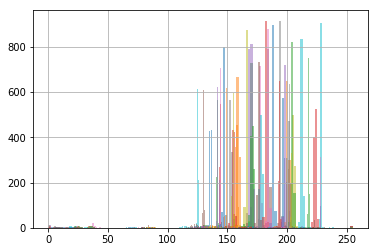

In [11]:
start = time.time()

#n = 1 if debug else 10
n = 2
figure = np.zeros((img_rows, img_cols * 10, img_chns))
print(figure.shape)
num_samples = min(n, batch_size)
for i in range(1):
    samples = gen_image(model, num_samples=num_samples)
    for j in range(num_samples):
        img = samples[j] / 255.
        d_x = ((i * batch_size + j) // 10) * img_rows
        d_y = ((i * batch_size + j) % 10) * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        
plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

In [ ]:
for i in range(num_sample):
    plt.figure(figsize=(2, 2))
    plt.imshow((X_train[i] * 127.5 + 127.5) / 255.)
    plt.show()

plt.figure(figsize=(20, 16))
plt.imshow(figure)
plt.show()

# 2019-06-03

* I *think* I fixed the loss function in two ways:
  * I updated the offset for the exception and normal case, should be correct now
  * I think I was doing an extra `K.sum()` at the end of the loss function, essentially summing up the entire batch's loss vs. just summing each item's loss.  Keras probably takes a `mean` at the end over the batch dimension, so probably no need to do a `sum`.  After this change, the reported loss looks more normal with los bits/pixel.
* Right now, I'm trying smaller examples 4x4 with 2 images using 5 mixture components, I get some funky results, still need to experiment a bit more.  Although, before the `sum` change above, I did get something that looked kind of reasonable.  So it's probably just a bad run, too many mixture components, or maybe the `sum` change is weird.

TODO: Play around a bit more, change mixture components, see if I can get an image that looks reasonable.

# 2019-06-08

* Sped up the image generation, don't use `scipy.logistic.cdf`, it's too slow.  Instead just use `sigmoid` directly.
  * Had to add an exception case to `sigmoid` prevent overflow.
* It looks like the network is not properly distinguishing between the two images, it looks like it learns certain local parts but doesn't separate them when generating a new image. Wonder why that's happening?
* Tried 9x9 convolution at beginning but still no dice.  Some ideas:
  * Might be overfiting?  Althought seems unlikely... bits/pixel is low-ish but even when it was higher it didn't have the same problems
  * Could be the adjustment I made on the loss function (to fix the exception case)?
  * Some other reason???
